In [1]:
from shared.preface import *
import shared.functions as fct

## Grid building tests.

### 2D grid, center coord. pairs.

In [ ]:
def grid_2D(l, s):

    # 2D spatial grid, discretized.
    eps = s/10
    x, y = np.mgrid[-l:l+eps:s, -l:l+eps:s]

    # [x y] edge coordinate pairs of above grid.
    xy = np.mgrid[-l:l+eps:s, -l:l+eps:s].reshape(2,-1).T

    # Create center coord.-pairs.
    x_centers = (x[1:,:] + x[:-1,:])/2.
    y_centers = (y[:,1:] + y[:,:-1])/2.
    centers = np.array([x_centers[:,:-1], y_centers[:-1,:]])
    cent_coordPairs2D = centers.reshape(2,-1).T
    print('All coord. pairs 2D:\n', cent_coordPairs2D)
    # print('Coord pairs 2D shape:', cent_coordPairs2D.shape)

    return cent_coordPairs2D

limit_coarse, space_coarse = 1.5, 1.
cent_coordPairs2D = grid_2D(limit_coarse, space_coarse)

# Delete middle square.
cent_coordPairs2D = np.delete(cent_coordPairs2D, 4, axis=0)

# Create finegrained square.
limit_fine, space_fine = limit_coarse/2., space_coarse/2.
cent_coordPairs2D_fine = grid_2D(limit_fine, space_fine)

# Insert finegrained square.

### 3D grid, center coord. pairs.

In [ ]:
# 3D spatial grid, discretized.
x, y, z = np.mgrid[-1:1.1:1., -1:1.1:1., -1:1.1:1.]
# print(x[0,...], x.shape)

x_centers = (x[1:,...] + x[:-1,...])/2.
# print(x_centers, x_centers.shape)

y_centers = (y[:,1:,:] + y[:,:-1,:])/2.
# print(y_centers, y_centers.shape)

z_centers = (z[...,1:] + z[...,:-1])/2.
# print(z_centers, z_centers.shape)


# Create center coord.-pairs., truncate redundant points.
centers3D = np.array([
    x_centers[:,:-1,:-1], 
    y_centers[:-1,:,:-1], 
    z_centers[:-1,:-1,:]
])
# print(centers3D, centers3D.shape)

cent_coordPairs3D = centers3D.reshape(3,-1).T 
print(cent_coordPairs3D, cent_coordPairs3D.shape)

## Analyze gravity.

In [ ]:
DM = np.load(f'sim_data/DM_positions_halos_M12.npy')[::1]
print(f'DM particles: {len(DM)}')
snap = '0036'

# Initialize grid and DM positions.
grid = fct.grid_3D(GRID_L, GRID_S)

z = 0
NFW_grav = np.array([
    fct.dPsi_dxi_NFW(x_i, z, rho0_MW, Mvir_MW, Rvir_MW, Rs_MW, 'MW')
    for x_i in grid
])
NFW_grav_mag = np.sqrt(np.sum(NFW_grav**2, axis=1))


grid = np.expand_dims(grid, axis=1)
DM = np.expand_dims(DM, axis=0)
DM = np.repeat(DM, len(grid), axis=0)

fig, ax = plt.subplots(1,1)

fct.cell_gravity_3D(grid, DM*kpc, rangeX, DM_SIM_MASS, snap, test_names=True)
dPsi_grid = np.load(f'CubeSpace/dPsi_grid_snapshot_TestFile.npy')
mags = np.sqrt(np.sum(dPsi_grid**2, axis=1))

# Sort cells by distance from center (0,0,0).
grid_dis = np.sqrt(np.sum(grid**2, axis=2)).flatten()
dis_ind = grid_dis.argsort()
grid_dis = grid_dis[dis_ind]
mags_rangeX = mags_rangeX[dis_ind]
NFW_grav_sort = NFW_grav_mag[dis_ind]

diff = (NFW_grav_sort-mags_rangeX)/NFW_grav_sort

if rangeX is None:
    rangeX = np.inf

ax.scatter(
    grid_dis/kpc, diff, s=5, alpha=0.8, 
    label=f'grav_range {np.round(rangeX/kpc,1)} kpc ({l0})'
    )

ax.set_title(
    f'Difference of sim vs. NFW (>1 stronger, 1 same, 0 bad)'
    '\n'
    'Multiple dots for each x-axis point, since multiple cells share same distance'
    )
ax.set_xlabel(f'Cell distance from center (kpc)')
ax.set_ylabel(f'sim grav. strength w.r.t NFW')

def y_fmt_here(value, tick_number):
    return np.round(1-value,1)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt_here))

# ax.set_ylim(-0.5,1)
plt.legend(loc='lower right')
plt.savefig('figures/sim_vs_NFW_gravity.pdf')
plt.show()

## Visualize cells after cell divisions.

Input data shapes (343, 1, 3) (343, 150358, 3)
cell division rounds: 4
Shapes of output files: (385, 1, 3) (385,) (385, 3) (385,)
Total DM count across all cells: 150358
150358


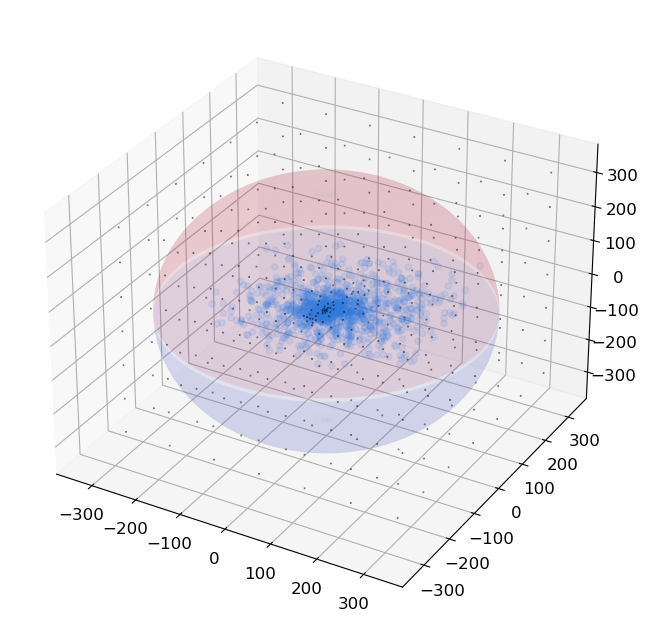

In [4]:
# Parameters.
snap = '0036'
m0 = '2.59e+11'

# Overwrite global DM_LIM parameter, to manually set rounds of cell division.
# DM_LIM = 100000  # round(s): 0
# DM_LIM = 50000   # round(s): 1
# DM_LIM = 40000   # round(s): 2
DM_LIM = 10000   # round(s): 4
# DM_LIM = 1000    # round(s): 8

# Initial grid and DM positions.
grid = fct.grid_3D(GRID_L, GRID_S)
init_cc = np.expand_dims(grid, axis=1)
DM_raw = np.load(
    f'CubeSpace/DM_positions_{SIM_ID}_snapshot_{snap}_{m0}Msun.npy'
)*kpc
DM_pos = np.expand_dims(DM_raw, axis=0)
DM_ready = np.repeat(DM_pos, len(init_cc), axis=0)
print('Input data shapes', init_cc.shape, DM_ready.shape)

cell_division_count = fct.cell_division(
    init_cc, DM_ready, GRID_S, DM_LIM, 
    stable_cc=None, sim=SIM_ID, snap_num=snap, 
    test_names=True  #! s.t. important files don't get changed
)
print(f'cell division rounds: {cell_division_count}')

# Output.
adapted_cc = np.load(
    f'CubeSpace/adapted_cc_TestFile_snapshot_{snap}.npy')
cell_gen = np.load(
    f'CubeSpace/cell_gen_TestFile_snapshot_{snap}.npy')
cell_com = np.load(
    f'CubeSpace/cell_com_TestFile_snapshot_{snap}.npy')
DM_count = np.load(
    f'CubeSpace/DM_count_TestFile_snapshot_{snap}.npy')

print('Shapes of output files:', adapted_cc.shape, cell_gen.shape, cell_com.shape, DM_count.shape)

print('Total DM count across all cells:', DM_count.sum())


################################################
### Plotting the outcome after iteration(s). ###
################################################

# Build grid around Milky Way.
new_grid = np.squeeze(adapted_cc, axis=1) / kpc

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

print(f'{len(DM_raw)}')
DM_raw /= kpc
x_DM, y_DM, z_DM = DM_raw[:,0], DM_raw[:,1], DM_raw[:,2]
cut = 100
x, y, z = x_DM[1::cut], y_DM[1::cut], z_DM[1::cut]

ax.scatter(x, y, z, alpha=0.1, c='dodgerblue')

# Draw sphere around GC with radius=Rvir_MW.
rGC = Rvir_MW/kpc
uGC, vGC = np.mgrid[0:2 * np.pi:200j, 0:np.pi:100j]
xGC = rGC * np.cos(uGC) * np.sin(vGC)
yGC = rGC * np.sin(uGC) * np.sin(vGC)
zGC = rGC * np.cos(vGC)

xg, yg, zg = new_grid[:,0], new_grid[:,1], new_grid[:,2] 
ax.scatter(xg, yg, zg, s=0.2, marker='x', color='black', alpha=0.5)


ax.plot_surface(
    xGC, yGC, zGC, alpha=0.1, 
    cmap=plt.cm.coolwarm, vmin=-1, vmax=1,# antialiased=False,
    rstride=1, cstride=1
)

# How many DM particles inside Virial Radius?
# DM_dists = np.sqrt(np.sum(DM_raw**2, axis=1))
# inside_VR = DM_pos[DM_dists <= rGC]
# print(len(inside_VR))

plt.show()

## Visualize halo mass evolution through snapshots.

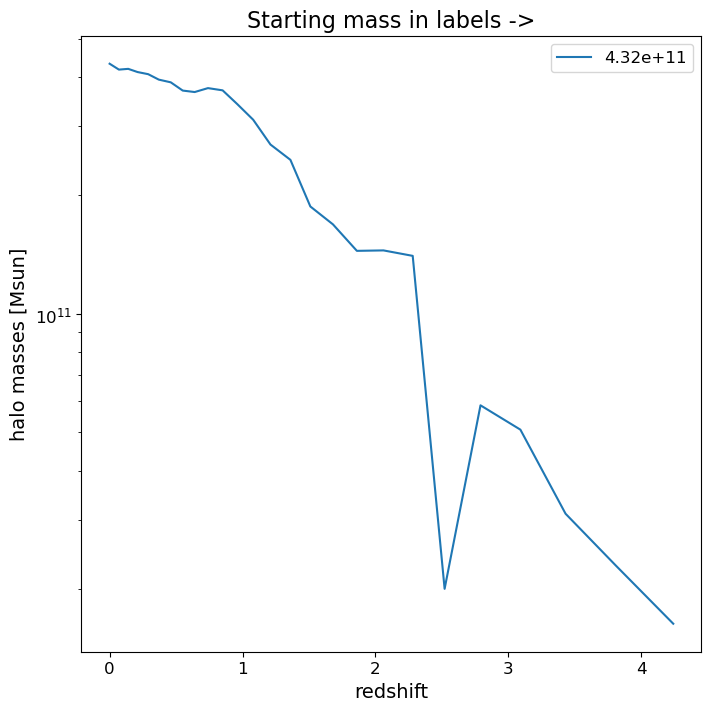

In [5]:
sim_ID = 'L006N188'

# Path to merger_tree file (has to have been generated with merger_tree.py)
tree_path = f'{pathlib.Path.cwd().parent}/neutrino_clustering_output_local/MergerTree/MergerTree_{sim_ID}.hdf5'

with h5py.File(tree_path) as tree:
    choice = 1  #note: 0 is ~1e12Msun, 1 & 2 are ~1e11Msun
    Masses = tree['Assembly_history/Mass'][choice,:]
    zeds = tree['Assembly_history/Redshift']
    
    y = np.asarray(Masses)
    x = np.asarray(zeds)

    fig = plt.figure()
    plt.semilogy(x, y, label=f'{y[0]:.2e}')
    plt.title(u'Starting mass in labels ->')
    plt.xlabel('redshift')
    plt.ylabel('halo masses [Msun]')
    plt.legend()
    plt.show()